In [1]:
# Parameters
usernames = "H"


In [2]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
from astropy.table import Column
from IPython.display import clear_output

/Users/suddin/.matplotlib is not a writable directory


Matplotlib created a temporary cache directory at /var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/matplotlib-y93bxnz5 because there was an issue with the default path (/Users/suddin/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Matplotlib is building the font cache; this may take a moment.


In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


In [4]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [5]:
#data
filter = f"{usernames}" # Run

#filter = 'u'
file = filter+'_sbfj21_update3.csv' # change the filaname here if needed for other bands or for other calibrators
tab = ascii.read('../data/'+file)


print(tab.columns)

<TableColumns names=('sn','zhel','zcmb','st','est','Mmax','eMmax','t0','EBVmw','eEBVmw','covMs','meth','BV','eBV','covBV_M','host','dist','edist','kmag','ekmag','dsbf','ed','m','em','ml','mu','sample','subtype','quality','caltype','covBVs')>


In [6]:
c = 300000.
q=-0.53

In [7]:
if not 'SN2011iv' in tab['sn']:
    f = filter+'_trgb_update3.csv' # since SN2011iv is not in filter+'_sbfj21_update3.csv'! 
    t = ascii.read('../data/'+f)
    w = np.where(t['sn']=='SN2011iv')
    t =t[w]
    tab.add_row({'sn':'SN2011iv','dist':31.453,'edist':0.084, 'st':t['st'],'est':t['est'],'Mmax':t['Mmax'], 'eMmax':t['eMmax'],'covMs':t['covMs'],'covBV_M':t['covBV_M'] })
else:
    pass
    
#if filter=='u':
    #if not 'SN2016ajf' in tab['sn']: ## on u-band only since it is missin in u-band SBFJ21 files taken from spreadsheeet: 
    #https://docs.google.com/spreadsheets/d/1DNMwdrrcdxqZYdLHKLKNyWrSCLxvBuFqlXmP18eO3qs/edit?gid=117582066#gid=117582066
 #   tab.add_row({'sn':'SN2016ajf', 'dist':34.202,'edist':0.106, 'st':0.493,'est':0.016,'Mmax':17.787, 'eMmax': 0.086, 'covMs':0.0,'covBV_M':0.0 })
#else:
 #   pass
    
    
#tab = ascii.read('../data/working/'+file)
st = tab['st']
est = tab['est']
zhel = tab['zhel']
zcmb = tab['zcmb']
mmax = tab['Mmax']
emmax = tab['eMmax']
bv = tab['BV']
ebv = tab['eBV']
m_csp = tab['m']
eml = (tab['m']-tab['ml'])
emu = (tab['mu']-tab['m'])
em = (emu+eml)/2.
dist = tab['dist']
edist = tab['edist']
c_ms = tab['covMs']
c_mbv = tab['covBV_M']
sn = tab['sn']

ebv_host = tab['EBVmw']

#adding more calibrators from Garnavich 2023
#1
c1 = np.where(sn =='SN2006mr') #31.200 ± 0.093
dist[c1]=31.2
edist[c1]=0.093
#2
c2 = np.where(sn =='SN2007on') # 31.453 ± 0.084
dist[c2]=31.453
edist[c2]=0.084
#3
c3 = np.where(sn =='SNhunt281')# 32.369,0.078 same as SN2015bp from Jensen 2021
dist[c3]=32.369
edist[c3]=0.078

# #4 Add SN2011iv

c4 = np.where(sn =='SN2011iv')# # 31.453 ± 0.084
dist[c4]=31.453
edist[c4]=0.084




In [8]:
#Mark's list for B-band 
supernovae = Column([
    "SN2004gs", "SN2005bl", "SN2005mc", "SN2006bd", "SN2006eq", "SN2006gj", "SN2006gt", "SN2006hb", "SN2006ob",
    "SN2007al", "SN2007ba", "SN2007hj", "SN2007jh", "SN2007mm", "SN2007N", "SN2007ol", "SN2007ux", "SN2008bd",
    "SN2008bi", "SN2008bt", "SN2008O", "SN2009F", "CSP12J", "CSP15B", "KISS15m", "LSQ11pn", "LSQ12fvl", "LSQ13dkp",
    "LSQ14act", "LSQ14ajn", "LSQ14gfb", "LSQ14ip", "LSQ14jp", "PTF11ppn", "PTF11pra", "PTF14aje", "PTF14w",
    "SN2011jn", "SN2012ij", "SN2013ay", "SN2013bc", "SN2014dn", "CSP13aao"
], name="Supernovae")

print(len(supernovae))
w0=[]

supernova_array = np.array(supernovae)
new_array = np.array(sn)

# Find indices of matching entries from supernova_column in new_column
match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in supernova_array])

for name, idx in zip(supernova_array, match):
    if idx != -1:
        #print(f"{name} found at index {idx} in new_column")
        
        w0.append(idx)
    else:
        print(f"{name} not found in new_column")
        

### Calibrators B          
calibrators = Column([
    "SN2007cv",
    "SN2008hs",
    "SN2010Y",
    "SN2014bv",
    "SN2016ajf",
    "SN2006mr",
    "SN2007on",
    "SN2008R",
    "SN2011iv",
    "PTF13ebh",
    "CSP15aae",
    "SNhunt281"
],name='Calibrators') 




w1=[]

calibrators_array = np.array(calibrators)
print(len(calibrators_array))

# Find indices of matching entries from supernova_column in new_column
match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in calibrators_array])

for name, idx in zip(calibrators_array, match):
    if idx != -1:
        #print(f"{name} found at index {idx} in new_column")
        
        w1.append(idx)
    else:
        pass
        #print(f"{name} not found in new_column")
         
        
        
        
        
print (sn[w1])

#print(sn[w0])
#print(sn[w1])


43
SN2005bl not found in new_column
SN2005mc not found in new_column
SN2007jh not found in new_column
SN2007mm not found in new_column
SN2007ol not found in new_column
CSP12J not found in new_column
CSP15B not found in new_column
LSQ13dkp not found in new_column
LSQ14act not found in new_column
LSQ14ajn not found in new_column
PTF11ppn not found in new_column
SN2011jn not found in new_column
SN2012ij not found in new_column
CSP13aao not found in new_column
12
    sn   
---------
 SN2008hs
  SN2010Y
 SN2006mr
 SN2007on
  SN2008R
 SN2011iv
 PTF13ebh
 CSP15aae
SNhunt281


In [9]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [10]:
# Liklihood function
def like(par):
    p,p1,p2,sig,h0 = par

    mu_obs=[]
    mu_model=[]
    mu_stat=[]
    
    if  -25.0<p<14.0  and -100.0<p1<100.0 and -100.0<p2<100.0 and  0.<sig<1. and 0< h0 < 1000.0: # priors
        

        
        mu_sn = mmax[w0] - p - p1*(bv[w0] - 0.4) -  p2*(bv[w0] - 0.4)**2

        mu_cal = mmax[w1] - p - p1*(bv[w1] - 0.4) -  p2*(bv[w1] - 0.4)**2 
        
        for mu_sn in mu_sn:
            mu_obs.append(mu_sn)
        for mu_cal in mu_cal:
            mu_obs.append(mu_cal)
        mu_model_sn = distmod(h0,zhel[w0],zcmb[w0])
        mu_model_cal = dist[w1]
        for mu_model_sn in mu_model_sn:
            mu_model.append(mu_model_sn)
        for mu_model_cal in mu_model_cal:
            mu_model.append(mu_model_cal)
        
        #fac= (p1+(2*p2*st[w0]))
        #fac1= (p1+(2*p2*st[w1]))
        
        fac= (p1+(2*p2*(bv[w0]-0.4)))
        fac1= (p1+(2*p2*(bv[w1]-0.4)))
        
        #velterm = (2.17*437.0)**2/(c*zcmb)**2
        vel = 300

        #err = (fac*ebv[w0])**2 +emmax[w0]**2 -2*(fac*c_mbv[w0]) +sig**2+(0.00000723*vel/zcmb[w0])**2
        #err1 = ((fac1*ebv[w1])**2) +(emmax[w1]**2) -2*(fac1*c_mbv[w1])+sig**2+(edist[w1]**2)
        err = (fac*ebv[w0])**2 +emmax[w0]**2 +sig**2+(0.00000723*vel/zcmb[w0])**2
        err1 = ((fac1*ebv[w1])**2) +(emmax[w1]**2) +sig**2+(edist[w1]**2)

        for err in err:
            mu_stat.append(err)
        for err1 in err1:
            mu_stat.append(err1)
        mu_stat=np.sqrt(mu_stat)

        mu_obs = np.array(mu_obs)
        mu_model = np.array(mu_model)
        mu_stat = np.array(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [11]:
#initial guess
plim=-17, -20
p1lim =-10,20
p2lim = -20,20

siglim=0,1
h0lim= 50.0,100

# EMCEE
ndim, nwalkers = 5, 50
ssize=1000
burnin = 500


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

#p0 = zip(*[p00,p10,p20,rv0,alpha0,sig0,vel0,h00])
p0 = np.array([p00,p10,p20,sig0,h00]).T


In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

running mcmc on H_sbfj21_update3.csv


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<00:50, 19.80it/s]

  0%|          | 5/1000 [00:00<00:45, 21.82it/s]

  1%|          | 8/1000 [00:00<00:45, 21.76it/s]

  1%|          | 11/1000 [00:00<00:48, 20.45it/s]

  1%|▏         | 14/1000 [00:00<00:48, 20.34it/s]

  2%|▏         | 17/1000 [00:00<00:48, 20.18it/s]

  2%|▏         | 20/1000 [00:00<00:48, 20.04it/s]

  2%|▏         | 23/1000 [00:01<00:48, 19.96it/s]

  2%|▎         | 25/1000 [00:01<00:49, 19.86it/s]

  3%|▎         | 27/1000 [00:01<00:49, 19.78it/s]

  3%|▎         | 29/1000 [00:01<00:50, 19.38it/s]

  3%|▎         | 31/1000 [00:01<00:52, 18.45it/s]

  3%|▎         | 33/1000 [00:01<00:51, 18.67it/s]

  4%|▎         | 35/1000 [00:01<00:50, 18.96it/s]

  4%|▎         | 37/1000 [00:01<00:50, 19.20it/s]

  4%|▍         | 39/1000 [00:01<00:49, 19.26it/s]

  4%|▍         | 41/1000 [00:02<00:49, 19.44it/s]

  4%|▍         | 43/1000 [00:02<00:49, 19.40it/s]

  4%|▍         | 45/1000 [00:02<00:49, 19.41it/s]

  5%|▍         | 47/1000 [00:02<00:48, 19.49it/s]

  5%|▍         | 49/1000 [00:02<00:50, 18.90it/s]

  5%|▌         | 51/1000 [00:02<00:51, 18.54it/s]

  5%|▌         | 53/1000 [00:02<00:50, 18.86it/s]

  6%|▌         | 55/1000 [00:02<00:49, 19.02it/s]

  6%|▌         | 57/1000 [00:03<01:00, 15.57it/s]

  6%|▌         | 60/1000 [00:03<00:54, 17.24it/s]

  6%|▋         | 63/1000 [00:03<00:51, 18.35it/s]

  6%|▋         | 65/1000 [00:03<00:50, 18.58it/s]

  7%|▋         | 67/1000 [00:03<00:51, 17.98it/s]

  7%|▋         | 69/1000 [00:03<00:50, 18.38it/s]

  7%|▋         | 71/1000 [00:03<00:49, 18.66it/s]

  7%|▋         | 73/1000 [00:03<00:48, 18.92it/s]

  8%|▊         | 75/1000 [00:03<00:48, 19.08it/s]

  8%|▊         | 77/1000 [00:04<00:47, 19.25it/s]

  8%|▊         | 79/1000 [00:04<00:47, 19.40it/s]

  8%|▊         | 81/1000 [00:04<00:47, 19.53it/s]

  8%|▊         | 84/1000 [00:04<00:46, 19.74it/s]

  9%|▊         | 86/1000 [00:04<00:47, 19.29it/s]

  9%|▉         | 88/1000 [00:04<00:48, 18.98it/s]

  9%|▉         | 90/1000 [00:04<00:47, 19.18it/s]

  9%|▉         | 92/1000 [00:04<00:47, 19.21it/s]

  9%|▉         | 94/1000 [00:04<00:47, 19.26it/s]

 10%|▉         | 96/1000 [00:05<00:47, 19.17it/s]

 10%|▉         | 98/1000 [00:05<00:47, 19.10it/s]

 10%|█         | 100/1000 [00:05<00:46, 19.21it/s]

 10%|█         | 102/1000 [00:05<00:46, 19.26it/s]

 10%|█         | 104/1000 [00:05<00:46, 19.21it/s]

 11%|█         | 106/1000 [00:05<00:49, 18.24it/s]

 11%|█         | 108/1000 [00:05<00:48, 18.40it/s]

 11%|█         | 110/1000 [00:05<00:47, 18.69it/s]

 11%|█         | 112/1000 [00:05<00:47, 18.87it/s]

 11%|█▏        | 114/1000 [00:05<00:46, 19.11it/s]

 12%|█▏        | 116/1000 [00:06<00:45, 19.31it/s]

 12%|█▏        | 118/1000 [00:06<00:45, 19.33it/s]

 12%|█▏        | 120/1000 [00:06<00:45, 19.42it/s]

 12%|█▏        | 122/1000 [00:06<00:45, 19.32it/s]

 12%|█▏        | 124/1000 [00:06<00:45, 19.40it/s]

 13%|█▎        | 126/1000 [00:06<00:45, 19.37it/s]

 13%|█▎        | 128/1000 [00:06<00:44, 19.42it/s]

 13%|█▎        | 130/1000 [00:06<00:44, 19.47it/s]

 13%|█▎        | 132/1000 [00:06<00:44, 19.42it/s]

 13%|█▎        | 134/1000 [00:06<00:45, 19.18it/s]

 14%|█▎        | 136/1000 [00:07<00:44, 19.23it/s]

 14%|█▍        | 138/1000 [00:07<00:44, 19.28it/s]

 14%|█▍        | 140/1000 [00:07<00:44, 19.33it/s]

 14%|█▍        | 142/1000 [00:07<00:44, 19.35it/s]

 14%|█▍        | 144/1000 [00:07<00:44, 19.21it/s]

 15%|█▍        | 146/1000 [00:07<00:44, 19.02it/s]

 15%|█▍        | 148/1000 [00:07<00:44, 19.15it/s]

 15%|█▌        | 150/1000 [00:07<00:44, 19.22it/s]

 15%|█▌        | 152/1000 [00:07<00:43, 19.31it/s]

 15%|█▌        | 154/1000 [00:08<00:44, 19.19it/s]

 16%|█▌        | 156/1000 [00:08<00:44, 19.13it/s]

 16%|█▌        | 158/1000 [00:08<00:43, 19.22it/s]

 16%|█▌        | 160/1000 [00:08<00:43, 19.24it/s]

 16%|█▌        | 162/1000 [00:08<00:43, 19.30it/s]

 16%|█▋        | 164/1000 [00:08<00:43, 19.38it/s]

 17%|█▋        | 166/1000 [00:08<00:43, 19.37it/s]

 17%|█▋        | 168/1000 [00:08<00:42, 19.42it/s]

 17%|█▋        | 170/1000 [00:08<00:42, 19.33it/s]

 17%|█▋        | 172/1000 [00:08<00:42, 19.50it/s]

 17%|█▋        | 174/1000 [00:09<00:50, 16.20it/s]

 18%|█▊        | 177/1000 [00:09<00:46, 17.67it/s]

 18%|█▊        | 179/1000 [00:09<00:44, 18.25it/s]

 18%|█▊        | 182/1000 [00:09<00:43, 18.95it/s]

 18%|█▊        | 185/1000 [00:09<00:42, 19.35it/s]

 19%|█▊        | 187/1000 [00:09<00:41, 19.42it/s]

 19%|█▉        | 189/1000 [00:09<00:41, 19.43it/s]

 19%|█▉        | 191/1000 [00:09<00:41, 19.53it/s]

 19%|█▉        | 193/1000 [00:10<00:41, 19.61it/s]

 20%|█▉        | 195/1000 [00:10<00:40, 19.65it/s]

 20%|█▉        | 197/1000 [00:10<00:41, 19.57it/s]

 20%|█▉        | 199/1000 [00:10<00:40, 19.57it/s]

 20%|██        | 201/1000 [00:10<00:40, 19.51it/s]

 20%|██        | 203/1000 [00:10<00:41, 19.27it/s]

 20%|██        | 205/1000 [00:10<00:41, 19.15it/s]

 21%|██        | 207/1000 [00:10<00:41, 19.24it/s]

 21%|██        | 209/1000 [00:10<00:41, 19.26it/s]

 21%|██        | 211/1000 [00:11<00:40, 19.33it/s]

 21%|██▏       | 213/1000 [00:11<00:40, 19.28it/s]

 22%|██▏       | 215/1000 [00:11<00:40, 19.40it/s]

 22%|██▏       | 217/1000 [00:11<00:40, 19.45it/s]

 22%|██▏       | 219/1000 [00:11<00:41, 18.94it/s]

 22%|██▏       | 221/1000 [00:11<00:41, 18.63it/s]

 22%|██▏       | 223/1000 [00:11<00:41, 18.82it/s]

 22%|██▎       | 225/1000 [00:11<00:41, 18.90it/s]

 23%|██▎       | 227/1000 [00:11<00:40, 18.99it/s]

 23%|██▎       | 229/1000 [00:11<00:40, 19.22it/s]

 23%|██▎       | 231/1000 [00:12<00:39, 19.30it/s]

 23%|██▎       | 233/1000 [00:12<00:39, 19.33it/s]

 24%|██▎       | 235/1000 [00:12<00:39, 19.44it/s]

 24%|██▎       | 237/1000 [00:12<00:39, 19.41it/s]

 24%|██▍       | 239/1000 [00:12<00:38, 19.52it/s]

 24%|██▍       | 241/1000 [00:12<00:39, 19.33it/s]

 24%|██▍       | 243/1000 [00:12<00:38, 19.51it/s]

 24%|██▍       | 245/1000 [00:12<00:38, 19.53it/s]

 25%|██▍       | 247/1000 [00:12<00:39, 19.26it/s]

 25%|██▍       | 249/1000 [00:12<00:39, 18.99it/s]

 25%|██▌       | 251/1000 [00:13<00:39, 19.10it/s]

 25%|██▌       | 253/1000 [00:13<00:39, 19.07it/s]

 26%|██▌       | 255/1000 [00:13<00:38, 19.19it/s]

 26%|██▌       | 257/1000 [00:13<00:38, 19.29it/s]

 26%|██▌       | 259/1000 [00:13<00:38, 19.32it/s]

 26%|██▌       | 261/1000 [00:13<00:38, 19.09it/s]

 26%|██▋       | 263/1000 [00:13<00:38, 19.20it/s]

 26%|██▋       | 265/1000 [00:13<00:38, 19.18it/s]

 27%|██▋       | 267/1000 [00:13<00:38, 19.14it/s]

 27%|██▋       | 269/1000 [00:14<00:38, 19.21it/s]

 27%|██▋       | 271/1000 [00:14<00:37, 19.28it/s]

 27%|██▋       | 273/1000 [00:14<00:37, 19.27it/s]

 28%|██▊       | 275/1000 [00:14<00:37, 19.34it/s]

 28%|██▊       | 277/1000 [00:14<00:37, 19.19it/s]

 28%|██▊       | 279/1000 [00:14<00:37, 19.08it/s]

 28%|██▊       | 281/1000 [00:14<00:37, 19.17it/s]

 28%|██▊       | 283/1000 [00:14<00:37, 19.24it/s]

 28%|██▊       | 285/1000 [00:14<00:37, 19.21it/s]

 29%|██▊       | 287/1000 [00:14<00:36, 19.32it/s]

 29%|██▉       | 289/1000 [00:15<00:36, 19.40it/s]

 29%|██▉       | 291/1000 [00:15<00:43, 16.42it/s]

 29%|██▉       | 293/1000 [00:15<00:40, 17.35it/s]

 30%|██▉       | 295/1000 [00:15<00:39, 18.05it/s]

 30%|██▉       | 298/1000 [00:15<00:37, 18.97it/s]

 30%|███       | 300/1000 [00:15<00:36, 19.18it/s]

 30%|███       | 302/1000 [00:15<00:36, 19.33it/s]

 30%|███       | 304/1000 [00:15<00:35, 19.46it/s]

 31%|███       | 306/1000 [00:15<00:35, 19.49it/s]

 31%|███       | 308/1000 [00:16<00:35, 19.61it/s]

 31%|███       | 310/1000 [00:16<00:35, 19.62it/s]

 31%|███       | 312/1000 [00:16<00:34, 19.70it/s]

 32%|███▏      | 315/1000 [00:16<00:34, 19.80it/s]

 32%|███▏      | 317/1000 [00:16<00:34, 19.56it/s]

 32%|███▏      | 319/1000 [00:16<00:34, 19.47it/s]

 32%|███▏      | 321/1000 [00:16<00:35, 19.35it/s]

 32%|███▏      | 323/1000 [00:16<00:35, 19.23it/s]

 32%|███▎      | 325/1000 [00:16<00:34, 19.29it/s]

 33%|███▎      | 327/1000 [00:17<00:34, 19.24it/s]

 33%|███▎      | 329/1000 [00:17<00:34, 19.31it/s]

 33%|███▎      | 331/1000 [00:17<00:34, 19.24it/s]

 33%|███▎      | 333/1000 [00:17<00:34, 19.34it/s]

 34%|███▎      | 335/1000 [00:17<00:34, 19.15it/s]

 34%|███▎      | 337/1000 [00:17<00:34, 19.13it/s]

 34%|███▍      | 339/1000 [00:17<00:34, 19.20it/s]

 34%|███▍      | 341/1000 [00:17<00:34, 19.29it/s]

 34%|███▍      | 343/1000 [00:17<00:33, 19.34it/s]

 34%|███▍      | 345/1000 [00:18<00:35, 18.53it/s]

 35%|███▍      | 347/1000 [00:18<00:35, 18.48it/s]

 35%|███▍      | 349/1000 [00:18<00:34, 18.75it/s]

 35%|███▌      | 351/1000 [00:18<00:34, 19.02it/s]

 35%|███▌      | 353/1000 [00:18<00:33, 19.19it/s]

 36%|███▌      | 355/1000 [00:18<00:33, 19.27it/s]

 36%|███▌      | 357/1000 [00:18<00:33, 19.38it/s]

 36%|███▌      | 359/1000 [00:18<00:32, 19.45it/s]

 36%|███▌      | 361/1000 [00:18<00:32, 19.51it/s]

 36%|███▋      | 363/1000 [00:18<00:32, 19.49it/s]

 36%|███▋      | 365/1000 [00:19<00:32, 19.54it/s]

 37%|███▋      | 367/1000 [00:19<00:32, 19.55it/s]

 37%|███▋      | 369/1000 [00:19<00:32, 19.61it/s]

 37%|███▋      | 371/1000 [00:19<00:32, 19.61it/s]

 37%|███▋      | 373/1000 [00:19<00:32, 19.49it/s]

 38%|███▊      | 375/1000 [00:19<00:32, 19.13it/s]

 38%|███▊      | 377/1000 [00:19<00:32, 19.26it/s]

 38%|███▊      | 379/1000 [00:19<00:32, 19.17it/s]

 38%|███▊      | 381/1000 [00:19<00:32, 19.27it/s]

 38%|███▊      | 383/1000 [00:19<00:31, 19.34it/s]

 38%|███▊      | 385/1000 [00:20<00:31, 19.37it/s]

 39%|███▊      | 387/1000 [00:20<00:31, 19.36it/s]

 39%|███▉      | 389/1000 [00:20<00:31, 19.50it/s]

 39%|███▉      | 391/1000 [00:20<00:31, 19.47it/s]

 39%|███▉      | 393/1000 [00:20<00:31, 19.49it/s]

 40%|███▉      | 395/1000 [00:20<00:30, 19.56it/s]

 40%|███▉      | 397/1000 [00:20<00:30, 19.47it/s]

 40%|███▉      | 399/1000 [00:20<00:30, 19.46it/s]

 40%|████      | 401/1000 [00:20<00:30, 19.46it/s]

 40%|████      | 403/1000 [00:21<00:31, 18.73it/s]

 40%|████      | 405/1000 [00:21<00:37, 15.69it/s]

 41%|████      | 407/1000 [00:21<00:35, 16.57it/s]

 41%|████      | 409/1000 [00:21<00:33, 17.46it/s]

 41%|████      | 411/1000 [00:21<00:33, 17.72it/s]

 41%|████▏     | 413/1000 [00:21<00:32, 18.02it/s]

 42%|████▏     | 415/1000 [00:21<00:31, 18.42it/s]

 42%|████▏     | 417/1000 [00:21<00:31, 18.61it/s]

 42%|████▏     | 419/1000 [00:21<00:31, 18.62it/s]

 42%|████▏     | 421/1000 [00:22<00:30, 18.87it/s]

 42%|████▏     | 423/1000 [00:22<00:30, 18.99it/s]

 42%|████▎     | 425/1000 [00:22<00:30, 19.16it/s]

 43%|████▎     | 427/1000 [00:22<00:29, 19.24it/s]

 43%|████▎     | 429/1000 [00:22<00:29, 19.36it/s]

 43%|████▎     | 431/1000 [00:22<00:31, 18.24it/s]

 43%|████▎     | 433/1000 [00:22<00:31, 17.75it/s]

 44%|████▎     | 435/1000 [00:22<00:31, 17.81it/s]

 44%|████▎     | 437/1000 [00:22<00:31, 17.61it/s]

 44%|████▍     | 439/1000 [00:23<00:32, 17.28it/s]

 44%|████▍     | 441/1000 [00:23<00:31, 17.72it/s]

 44%|████▍     | 443/1000 [00:23<00:30, 18.11it/s]

 44%|████▍     | 445/1000 [00:23<00:29, 18.52it/s]

 45%|████▍     | 447/1000 [00:23<00:29, 18.81it/s]

 45%|████▍     | 449/1000 [00:23<00:31, 17.61it/s]

 45%|████▌     | 451/1000 [00:23<00:31, 17.41it/s]

 45%|████▌     | 453/1000 [00:23<00:30, 17.82it/s]

 46%|████▌     | 455/1000 [00:23<00:29, 18.19it/s]

 46%|████▌     | 457/1000 [00:24<00:29, 18.50it/s]

 46%|████▌     | 459/1000 [00:24<00:28, 18.76it/s]

 46%|████▌     | 461/1000 [00:24<00:28, 18.92it/s]

 46%|████▋     | 463/1000 [00:24<00:28, 19.13it/s]

 46%|████▋     | 465/1000 [00:24<00:27, 19.24it/s]

 47%|████▋     | 467/1000 [00:24<00:28, 18.87it/s]

 47%|████▋     | 469/1000 [00:24<00:28, 18.35it/s]

 47%|████▋     | 471/1000 [00:24<00:28, 18.59it/s]

 47%|████▋     | 473/1000 [00:24<00:28, 18.76it/s]

 48%|████▊     | 475/1000 [00:24<00:27, 18.90it/s]

 48%|████▊     | 477/1000 [00:25<00:27, 18.69it/s]

 48%|████▊     | 479/1000 [00:25<00:27, 18.90it/s]

 48%|████▊     | 481/1000 [00:25<00:27, 18.91it/s]

 48%|████▊     | 483/1000 [00:25<00:27, 18.97it/s]

 48%|████▊     | 485/1000 [00:25<00:27, 18.99it/s]

 49%|████▊     | 487/1000 [00:25<00:28, 17.83it/s]

 49%|████▉     | 489/1000 [00:25<00:29, 17.57it/s]

 49%|████▉     | 491/1000 [00:25<00:29, 17.21it/s]

 49%|████▉     | 493/1000 [00:25<00:28, 17.75it/s]

 50%|████▉     | 495/1000 [00:26<00:27, 18.17it/s]

 50%|████▉     | 497/1000 [00:26<00:27, 18.45it/s]

 50%|████▉     | 499/1000 [00:26<00:26, 18.67it/s]

 50%|█████     | 501/1000 [00:26<00:26, 18.86it/s]

 50%|█████     | 503/1000 [00:26<00:26, 18.94it/s]

 50%|█████     | 505/1000 [00:26<00:29, 16.79it/s]

 51%|█████     | 507/1000 [00:26<00:29, 16.66it/s]

 51%|█████     | 509/1000 [00:26<00:30, 16.36it/s]

 51%|█████     | 511/1000 [00:27<00:29, 16.72it/s]

 51%|█████▏    | 514/1000 [00:27<00:31, 15.37it/s]

 52%|█████▏    | 517/1000 [00:27<00:28, 16.91it/s]

 52%|█████▏    | 520/1000 [00:27<00:26, 17.92it/s]

 52%|█████▏    | 522/1000 [00:27<00:26, 18.25it/s]

 52%|█████▏    | 524/1000 [00:27<00:25, 18.57it/s]

 53%|█████▎    | 526/1000 [00:27<00:25, 18.91it/s]

 53%|█████▎    | 528/1000 [00:27<00:25, 18.76it/s]

 53%|█████▎    | 530/1000 [00:28<00:24, 18.97it/s]

 53%|█████▎    | 532/1000 [00:28<00:24, 19.06it/s]

 53%|█████▎    | 534/1000 [00:28<00:24, 18.95it/s]

 54%|█████▎    | 536/1000 [00:28<00:24, 19.16it/s]

 54%|█████▍    | 538/1000 [00:28<00:23, 19.32it/s]

 54%|█████▍    | 540/1000 [00:28<00:23, 19.37it/s]

 54%|█████▍    | 542/1000 [00:28<00:23, 19.27it/s]

 54%|█████▍    | 544/1000 [00:28<00:23, 19.43it/s]

 55%|█████▍    | 546/1000 [00:28<00:23, 19.36it/s]

 55%|█████▍    | 548/1000 [00:28<00:23, 19.35it/s]

 55%|█████▌    | 550/1000 [00:29<00:23, 19.28it/s]

 55%|█████▌    | 552/1000 [00:29<00:23, 19.35it/s]

 55%|█████▌    | 554/1000 [00:29<00:23, 19.37it/s]

 56%|█████▌    | 556/1000 [00:29<00:22, 19.47it/s]

 56%|█████▌    | 558/1000 [00:29<00:22, 19.45it/s]

 56%|█████▌    | 560/1000 [00:29<00:24, 17.90it/s]

 56%|█████▌    | 562/1000 [00:29<00:24, 17.85it/s]

 56%|█████▋    | 564/1000 [00:29<00:23, 18.27it/s]

 57%|█████▋    | 566/1000 [00:29<00:23, 18.54it/s]

 57%|█████▋    | 568/1000 [00:30<00:23, 18.74it/s]

 57%|█████▋    | 570/1000 [00:30<00:22, 18.73it/s]

 57%|█████▋    | 572/1000 [00:30<00:22, 18.99it/s]

 57%|█████▋    | 574/1000 [00:30<00:22, 19.18it/s]

 58%|█████▊    | 576/1000 [00:30<00:21, 19.39it/s]

 58%|█████▊    | 578/1000 [00:30<00:22, 18.91it/s]

 58%|█████▊    | 580/1000 [00:30<00:22, 18.49it/s]

 58%|█████▊    | 582/1000 [00:30<00:22, 18.80it/s]

 58%|█████▊    | 584/1000 [00:30<00:21, 18.93it/s]

 59%|█████▊    | 586/1000 [00:30<00:21, 19.11it/s]

 59%|█████▉    | 588/1000 [00:31<00:21, 19.27it/s]

 59%|█████▉    | 590/1000 [00:31<00:21, 19.19it/s]

 59%|█████▉    | 592/1000 [00:31<00:21, 19.27it/s]

 59%|█████▉    | 594/1000 [00:31<00:21, 19.28it/s]

 60%|█████▉    | 596/1000 [00:31<00:21, 19.20it/s]

 60%|█████▉    | 598/1000 [00:31<00:22, 17.99it/s]

 60%|██████    | 600/1000 [00:31<00:22, 18.16it/s]

 60%|██████    | 602/1000 [00:31<00:21, 18.51it/s]

 60%|██████    | 604/1000 [00:31<00:21, 18.78it/s]

 61%|██████    | 606/1000 [00:32<00:20, 18.94it/s]

 61%|██████    | 608/1000 [00:32<00:20, 18.73it/s]

 61%|██████    | 610/1000 [00:32<00:20, 18.90it/s]

 61%|██████    | 612/1000 [00:32<00:20, 19.02it/s]

 61%|██████▏   | 614/1000 [00:32<00:20, 19.15it/s]

 62%|██████▏   | 616/1000 [00:32<00:20, 18.74it/s]

 62%|██████▏   | 618/1000 [00:32<00:20, 18.30it/s]

 62%|██████▏   | 620/1000 [00:32<00:20, 18.60it/s]

 62%|██████▏   | 622/1000 [00:32<00:20, 18.76it/s]

 62%|██████▏   | 624/1000 [00:32<00:19, 19.09it/s]

 63%|██████▎   | 626/1000 [00:33<00:23, 16.24it/s]

 63%|██████▎   | 629/1000 [00:33<00:20, 17.76it/s]

 63%|██████▎   | 632/1000 [00:33<00:19, 18.62it/s]

 63%|██████▎   | 634/1000 [00:33<00:19, 18.78it/s]

 64%|██████▎   | 636/1000 [00:33<00:19, 19.04it/s]

 64%|██████▍   | 638/1000 [00:33<00:18, 19.16it/s]

 64%|██████▍   | 640/1000 [00:33<00:18, 19.22it/s]

 64%|██████▍   | 642/1000 [00:33<00:18, 19.39it/s]

 64%|██████▍   | 644/1000 [00:34<00:18, 19.53it/s]

 65%|██████▍   | 647/1000 [00:34<00:17, 19.73it/s]

 65%|██████▌   | 650/1000 [00:34<00:17, 19.87it/s]

 65%|██████▌   | 652/1000 [00:34<00:17, 19.79it/s]

 65%|██████▌   | 654/1000 [00:34<00:18, 19.07it/s]

 66%|██████▌   | 656/1000 [00:34<00:18, 18.30it/s]

 66%|██████▌   | 658/1000 [00:34<00:19, 17.86it/s]

 66%|██████▌   | 660/1000 [00:34<00:18, 18.15it/s]

 66%|██████▌   | 662/1000 [00:35<00:18, 18.15it/s]

 66%|██████▋   | 664/1000 [00:35<00:18, 18.13it/s]

 67%|██████▋   | 666/1000 [00:35<00:18, 18.43it/s]

 67%|██████▋   | 668/1000 [00:35<00:18, 17.95it/s]

 67%|██████▋   | 670/1000 [00:35<00:18, 18.25it/s]

 67%|██████▋   | 672/1000 [00:35<00:18, 17.60it/s]

 67%|██████▋   | 674/1000 [00:35<00:18, 17.66it/s]

 68%|██████▊   | 676/1000 [00:35<00:17, 18.11it/s]

 68%|██████▊   | 678/1000 [00:35<00:17, 18.13it/s]

 68%|██████▊   | 680/1000 [00:36<00:17, 18.51it/s]

 68%|██████▊   | 682/1000 [00:36<00:16, 18.81it/s]

 68%|██████▊   | 684/1000 [00:36<00:16, 19.07it/s]

 69%|██████▊   | 686/1000 [00:36<00:16, 19.19it/s]

 69%|██████▉   | 688/1000 [00:36<00:16, 19.26it/s]

 69%|██████▉   | 690/1000 [00:36<00:16, 19.36it/s]

 69%|██████▉   | 692/1000 [00:36<00:16, 18.53it/s]

 69%|██████▉   | 694/1000 [00:36<00:16, 18.80it/s]

 70%|██████▉   | 696/1000 [00:36<00:16, 18.89it/s]

 70%|██████▉   | 698/1000 [00:36<00:15, 19.07it/s]

 70%|███████   | 700/1000 [00:37<00:15, 19.19it/s]

 70%|███████   | 702/1000 [00:37<00:15, 19.15it/s]

 70%|███████   | 704/1000 [00:37<00:15, 19.29it/s]

 71%|███████   | 706/1000 [00:37<00:15, 19.34it/s]

 71%|███████   | 708/1000 [00:37<00:15, 19.33it/s]

 71%|███████   | 710/1000 [00:37<00:15, 19.31it/s]

 71%|███████   | 712/1000 [00:37<00:14, 19.32it/s]

 71%|███████▏  | 714/1000 [00:37<00:14, 19.35it/s]

 72%|███████▏  | 716/1000 [00:37<00:14, 19.35it/s]

 72%|███████▏  | 718/1000 [00:38<00:14, 19.39it/s]

 72%|███████▏  | 720/1000 [00:38<00:14, 19.45it/s]

 72%|███████▏  | 722/1000 [00:38<00:14, 19.40it/s]

 72%|███████▏  | 724/1000 [00:38<00:14, 19.35it/s]

 73%|███████▎  | 726/1000 [00:38<00:14, 19.38it/s]

 73%|███████▎  | 728/1000 [00:38<00:13, 19.46it/s]

 73%|███████▎  | 730/1000 [00:38<00:13, 19.39it/s]

 73%|███████▎  | 732/1000 [00:38<00:13, 19.43it/s]

 73%|███████▎  | 734/1000 [00:38<00:13, 19.45it/s]

 74%|███████▎  | 736/1000 [00:38<00:16, 16.30it/s]

 74%|███████▍  | 738/1000 [00:39<00:15, 17.15it/s]

 74%|███████▍  | 741/1000 [00:39<00:14, 17.98it/s]

 74%|███████▍  | 744/1000 [00:39<00:13, 18.66it/s]

 75%|███████▍  | 747/1000 [00:39<00:13, 19.23it/s]

 75%|███████▍  | 749/1000 [00:39<00:12, 19.37it/s]

 75%|███████▌  | 751/1000 [00:39<00:12, 19.20it/s]

 75%|███████▌  | 753/1000 [00:39<00:12, 19.25it/s]

 76%|███████▌  | 755/1000 [00:39<00:12, 19.23it/s]

 76%|███████▌  | 757/1000 [00:40<00:12, 19.30it/s]

 76%|███████▌  | 759/1000 [00:40<00:12, 19.34it/s]

 76%|███████▌  | 761/1000 [00:40<00:12, 19.37it/s]

 76%|███████▋  | 763/1000 [00:40<00:12, 19.32it/s]

 76%|███████▋  | 765/1000 [00:40<00:12, 19.42it/s]

 77%|███████▋  | 767/1000 [00:40<00:12, 19.39it/s]

 77%|███████▋  | 769/1000 [00:40<00:12, 19.24it/s]

 77%|███████▋  | 771/1000 [00:40<00:11, 19.21it/s]

 77%|███████▋  | 773/1000 [00:40<00:12, 18.77it/s]

 78%|███████▊  | 775/1000 [00:41<00:11, 18.89it/s]

 78%|███████▊  | 777/1000 [00:41<00:11, 18.87it/s]

 78%|███████▊  | 779/1000 [00:41<00:11, 18.99it/s]

 78%|███████▊  | 781/1000 [00:41<00:11, 19.06it/s]

 78%|███████▊  | 783/1000 [00:41<00:11, 19.00it/s]

 78%|███████▊  | 785/1000 [00:41<00:11, 19.06it/s]

 79%|███████▊  | 787/1000 [00:41<00:11, 18.42it/s]

 79%|███████▉  | 789/1000 [00:41<00:11, 18.52it/s]

 79%|███████▉  | 791/1000 [00:41<00:11, 18.65it/s]

 79%|███████▉  | 793/1000 [00:41<00:10, 18.85it/s]

 80%|███████▉  | 795/1000 [00:42<00:10, 18.94it/s]

 80%|███████▉  | 797/1000 [00:42<00:10, 19.06it/s]

 80%|███████▉  | 799/1000 [00:42<00:10, 19.10it/s]

 80%|████████  | 801/1000 [00:42<00:10, 19.12it/s]

 80%|████████  | 803/1000 [00:42<00:10, 19.10it/s]

 80%|████████  | 805/1000 [00:42<00:10, 18.99it/s]

 81%|████████  | 807/1000 [00:42<00:10, 18.84it/s]

 81%|████████  | 809/1000 [00:42<00:10, 18.98it/s]

 81%|████████  | 811/1000 [00:42<00:09, 19.08it/s]

 81%|████████▏ | 813/1000 [00:43<00:09, 19.20it/s]

 82%|████████▏ | 815/1000 [00:43<00:09, 19.21it/s]

 82%|████████▏ | 817/1000 [00:43<00:09, 19.18it/s]

 82%|████████▏ | 819/1000 [00:43<00:09, 19.24it/s]

 82%|████████▏ | 821/1000 [00:43<00:09, 19.16it/s]

 82%|████████▏ | 823/1000 [00:43<00:09, 19.23it/s]

 82%|████████▎ | 825/1000 [00:43<00:09, 18.93it/s]

 83%|████████▎ | 827/1000 [00:43<00:09, 19.01it/s]

 83%|████████▎ | 829/1000 [00:43<00:08, 19.09it/s]

 83%|████████▎ | 831/1000 [00:43<00:08, 19.11it/s]

 83%|████████▎ | 833/1000 [00:44<00:08, 19.21it/s]

 84%|████████▎ | 835/1000 [00:44<00:08, 19.17it/s]

 84%|████████▎ | 837/1000 [00:44<00:08, 19.24it/s]

 84%|████████▍ | 839/1000 [00:44<00:08, 19.31it/s]

 84%|████████▍ | 841/1000 [00:44<00:08, 19.34it/s]

 84%|████████▍ | 843/1000 [00:44<00:08, 19.37it/s]

 84%|████████▍ | 845/1000 [00:44<00:09, 16.82it/s]

 85%|████████▍ | 847/1000 [00:44<00:11, 13.28it/s]

 85%|████████▍ | 849/1000 [00:45<00:12, 12.56it/s]

 85%|████████▌ | 851/1000 [00:45<00:10, 13.68it/s]

 85%|████████▌ | 853/1000 [00:45<00:10, 14.49it/s]

 86%|████████▌ | 855/1000 [00:45<00:09, 15.78it/s]

 86%|████████▌ | 857/1000 [00:45<00:08, 16.84it/s]

 86%|████████▌ | 860/1000 [00:45<00:07, 17.91it/s]

 86%|████████▌ | 862/1000 [00:45<00:07, 18.21it/s]

 86%|████████▋ | 864/1000 [00:45<00:07, 18.51it/s]

 87%|████████▋ | 866/1000 [00:46<00:07, 18.69it/s]

 87%|████████▋ | 868/1000 [00:46<00:06, 19.04it/s]

 87%|████████▋ | 870/1000 [00:46<00:06, 19.25it/s]

 87%|████████▋ | 872/1000 [00:46<00:06, 19.40it/s]

 87%|████████▋ | 874/1000 [00:46<00:06, 19.25it/s]

 88%|████████▊ | 876/1000 [00:46<00:06, 18.58it/s]

 88%|████████▊ | 878/1000 [00:46<00:06, 17.92it/s]

 88%|████████▊ | 880/1000 [00:46<00:06, 18.29it/s]

 88%|████████▊ | 882/1000 [00:46<00:06, 18.34it/s]

 88%|████████▊ | 884/1000 [00:46<00:06, 18.65it/s]

 89%|████████▊ | 886/1000 [00:47<00:06, 18.89it/s]

 89%|████████▉ | 888/1000 [00:47<00:05, 19.04it/s]

 89%|████████▉ | 890/1000 [00:47<00:05, 19.17it/s]

 89%|████████▉ | 892/1000 [00:47<00:05, 19.31it/s]

 89%|████████▉ | 894/1000 [00:47<00:05, 19.38it/s]

 90%|████████▉ | 896/1000 [00:47<00:05, 18.49it/s]

 90%|████████▉ | 898/1000 [00:47<00:05, 18.58it/s]

 90%|█████████ | 900/1000 [00:47<00:05, 18.74it/s]

 90%|█████████ | 902/1000 [00:47<00:05, 18.92it/s]

 90%|█████████ | 904/1000 [00:48<00:05, 17.70it/s]

 91%|█████████ | 906/1000 [00:48<00:05, 18.02it/s]

 91%|█████████ | 908/1000 [00:48<00:04, 18.44it/s]

 91%|█████████ | 910/1000 [00:48<00:04, 18.69it/s]

 91%|█████████ | 912/1000 [00:48<00:04, 18.88it/s]

 91%|█████████▏| 914/1000 [00:48<00:04, 18.57it/s]

 92%|█████████▏| 916/1000 [00:48<00:04, 18.54it/s]

 92%|█████████▏| 918/1000 [00:48<00:04, 18.78it/s]

 92%|█████████▏| 920/1000 [00:48<00:04, 18.83it/s]

 92%|█████████▏| 922/1000 [00:49<00:04, 19.03it/s]

 92%|█████████▏| 924/1000 [00:49<00:03, 19.15it/s]

 93%|█████████▎| 926/1000 [00:49<00:03, 19.23it/s]

 93%|█████████▎| 928/1000 [00:49<00:03, 19.28it/s]

 93%|█████████▎| 930/1000 [00:49<00:03, 19.32it/s]

 93%|█████████▎| 932/1000 [00:49<00:03, 19.20it/s]

 93%|█████████▎| 934/1000 [00:49<00:03, 18.63it/s]

 94%|█████████▎| 936/1000 [00:49<00:03, 18.73it/s]

 94%|█████████▍| 938/1000 [00:49<00:03, 18.88it/s]

 94%|█████████▍| 940/1000 [00:49<00:03, 18.93it/s]

 94%|█████████▍| 942/1000 [00:50<00:03, 19.05it/s]

 94%|█████████▍| 944/1000 [00:50<00:02, 19.10it/s]

 95%|█████████▍| 946/1000 [00:50<00:02, 19.23it/s]

 95%|█████████▍| 948/1000 [00:50<00:02, 19.32it/s]

 95%|█████████▌| 950/1000 [00:50<00:02, 19.21it/s]

 95%|█████████▌| 952/1000 [00:50<00:02, 19.15it/s]

 95%|█████████▌| 954/1000 [00:50<00:02, 15.47it/s]

 96%|█████████▌| 956/1000 [00:50<00:02, 16.41it/s]

 96%|█████████▌| 958/1000 [00:50<00:02, 17.27it/s]

 96%|█████████▌| 961/1000 [00:51<00:02, 18.51it/s]

 96%|█████████▋| 964/1000 [00:51<00:01, 19.20it/s]

 97%|█████████▋| 967/1000 [00:51<00:01, 19.56it/s]

 97%|█████████▋| 970/1000 [00:51<00:01, 19.82it/s]

 97%|█████████▋| 972/1000 [00:51<00:01, 19.78it/s]

 97%|█████████▋| 974/1000 [00:51<00:01, 19.35it/s]

 98%|█████████▊| 976/1000 [00:51<00:01, 19.32it/s]

 98%|█████████▊| 978/1000 [00:51<00:01, 19.17it/s]

 98%|█████████▊| 980/1000 [00:52<00:01, 19.22it/s]

 98%|█████████▊| 982/1000 [00:52<00:00, 19.07it/s]

 98%|█████████▊| 984/1000 [00:52<00:00, 19.02it/s]

 99%|█████████▊| 986/1000 [00:52<00:00, 19.09it/s]

 99%|█████████▉| 988/1000 [00:52<00:00, 19.06it/s]

 99%|█████████▉| 990/1000 [00:52<00:00, 19.00it/s]

 99%|█████████▉| 992/1000 [00:52<00:00, 19.03it/s]

 99%|█████████▉| 994/1000 [00:52<00:00, 19.06it/s]

100%|█████████▉| 996/1000 [00:52<00:00, 19.08it/s]

100%|█████████▉| 998/1000 [00:53<00:00, 19.11it/s]

100%|██████████| 1000/1000 [00:53<00:00, 19.13it/s]

100%|██████████| 1000/1000 [00:53<00:00, 18.82it/s]

Mean acceptance fraction: 0.5452


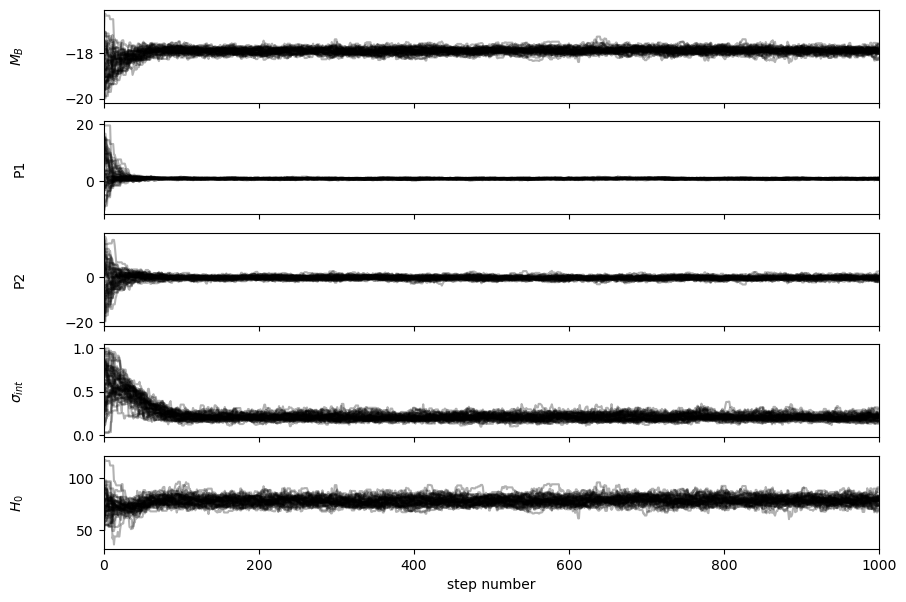

In [13]:
# Chains
clear_output(wait=True)

fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$M_B$",r"P1", r"P2",r"$\sigma_{int}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

fig.savefig("../results/colormethod/"+file[:-4]+"_chains.pdf")
pl.show()


In [14]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#tau = sampler.get_autocorr_time()
#print(tau)

 # Printing results
for i, name in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name}: {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")
    

$M_B$: -17.892 (+0.116/-0.112)
P1: 0.912 (+0.176/-0.184)
P2: -0.378 (+0.649/-0.656)
$\sigma_{int}$: 0.206 (+0.035/-0.032)
$H_0$: 78.350 (+3.869/-3.585)


In [15]:
# Writing Result
p0_mcmc,p1_mcmc,p2_mcmc,sig_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))



f1 =open('../results/colormethod/'+file[:-4]+'_result_color.txt','w') ### MUST change !!

f1.write('%s\t%s\t%s\t%s\t%s\n'%('p0','p1','p2','sig_int','H0'))

f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[0],p1_mcmc[0],p2_mcmc[0],sig_mcmc[0],H0_mcmc[0]))

f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[1],p1_mcmc[1],p2_mcmc[1],sig_mcmc[1],H0_mcmc[1]))
f1.write('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n'%(p0_mcmc[2],p1_mcmc[2],p2_mcmc[2],sig_mcmc[2],H0_mcmc[2]))

f1.close()

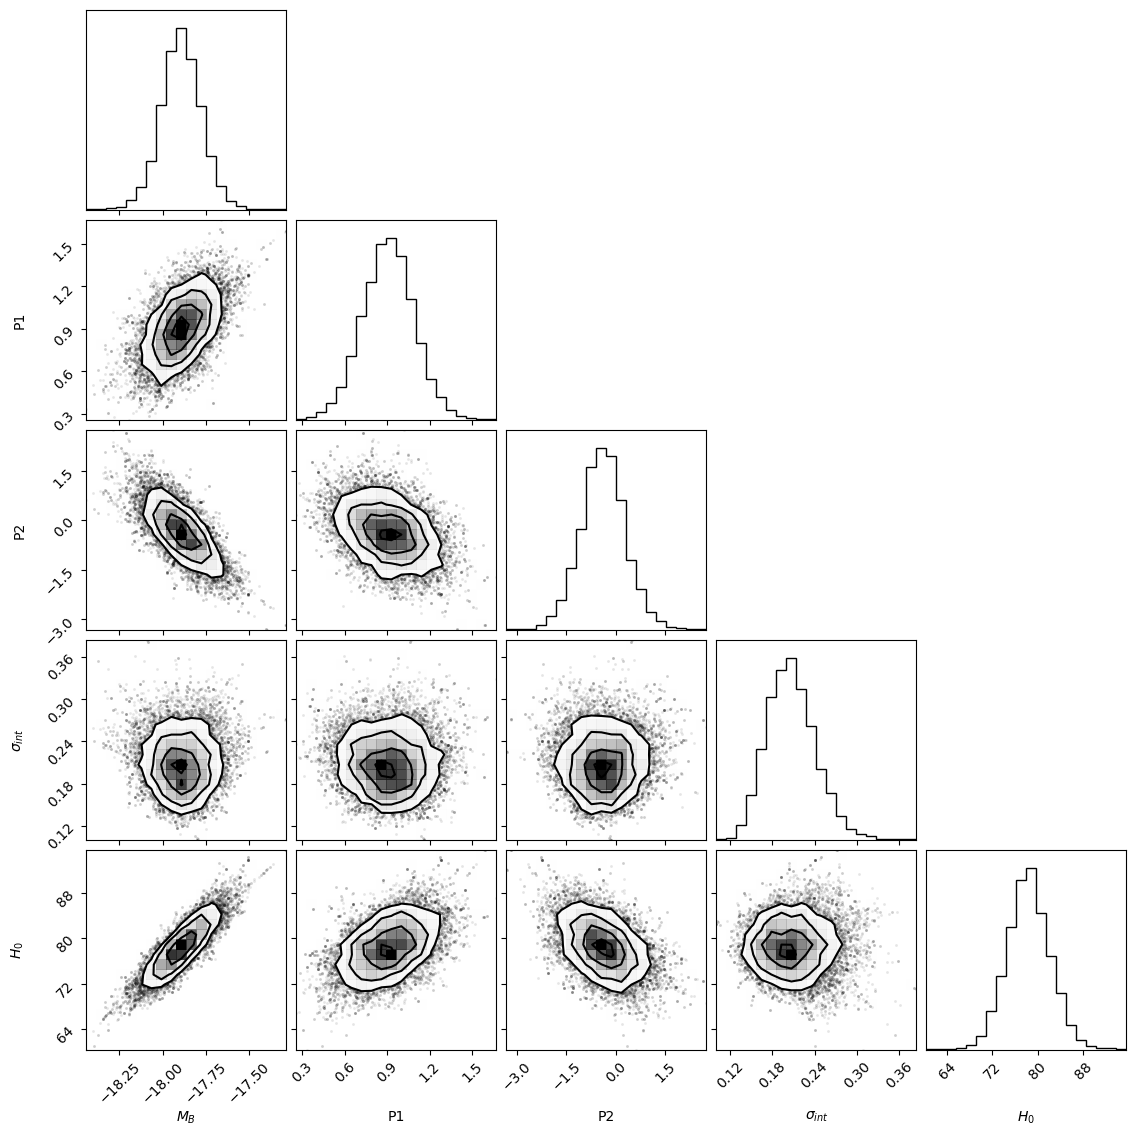

In [16]:
# Triangle plot
clear_output(wait=True)
figure = corner.corner(samples, labels = ["$M_B$","P1", "P2",r"$\sigma_{int}$", r"$H_0$"])
figure.savefig("../results/colormethod/"+file[:-4]+"_color"+str(nwalkers)+"_"+str(ssize)+".pdf")
pl.show()


In [17]:
import os

os.system('say "your program has finished."')


0